Menghubungkan ke Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Menyimpan hasil ekstrak ke dalam folder datasets
import zipfile,os
local_zip = "/content/drive/MyDrive/Colab Notebooks/Dataset_coba.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/datasets")
zip_ref.close()

Mengimpor Libraries yang digunakan

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from skimage.io import imread
from skimage.transform import resize
import cv2
from keras.models import Sequential
 
# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime
 
%load_ext autotime

time: 189 µs


In [ ]:
print(tf.__version__)

2.3.0
time: 925 µs


Preprocessing Datasets

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.2,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,    
    vertical_flip = True,
    fill_mode = "nearest")

time: 2.9 ms


Membuat Objek ImageDataGenertor dan Data Augmentation

Membuat obyek gambar dataset dengan ImageDataGenerator, augmentasi dataset dan membagi dataset validasi sebesar 20% dan dataset pelatihan sebesar 80%

Menggunakan Obyek Image Data Generator

In [ ]:
#Memuat dataset pelatihan & validasi
base_dir = os.path.join("/content/datasets/Dataset_coba/Train")
 
img_size =224
batch_size = 128
 
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='training')
 
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='validation')

 
#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Marah',
          'Sedih',
          'Senang']
 
for i,label in enumerate(labels):
    folder = os.path.join("/content/datasets/Dataset_coba/Test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)       
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)
 
X_test = np.array(X_test)
y_test = np.array(y_test)


 
#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape,)

Found 291 images belonging to 3 classes.
Found 71 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset validation (validasi) adalah: (71, 224, 224, 3) (71, 3)
Bentuk array dari dataset test (pengujian) adalah: (274, 224, 224, 3) (274,)
time: 7.46 s


Menyimpan Label Datasets

In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Marah': 0, 'Sedih': 1, 'Senang': 2}
time: 7.76 ms


Membuat model dari jaringan CNN yang sudah dipelajari sebelumnya (pre-trained covnets)

In [ ]:
IMG_SHAPE = (224,224, 3)
# Membuat model dasar (base model) dari pre-trained model 
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

time: 761 ms


Feature Extraction

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

Pembuatan Model (Menambah Model)

In [ ]:
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Conv2D(32, 3, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(3, activation='softmax')

])


time: 173 ms


In [ ]:
model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          294944    
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 3,523,907
Trainable params: 295,043
Non-trainable params: 3,228,864
_________________________________________________________________
time: 22.1 ms


Melatih model

In [ ]:
#es = EarlyStopping(monitor="val_loss", patience=7, verbose=1, min_delta=0.09, mode="auto")
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator)

Epoch 1/100
3/3 [==============================] - 4s 1s/step - loss: 1.0052 - acc: 0.4158 - val_loss: 1.0156 - val_acc: 0.4225
Epoch 2/100
3/3 [==============================] - 3s 993ms/step - loss: 0.9957 - acc: 0.4158 - val_loss: 1.0251 - val_acc: 0.4366
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 0.9779 - acc: 0.4364 - val_loss: 1.0013 - val_acc: 0.4366
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 0.9398 - acc: 0.4708 - val_loss: 1.0082 - val_acc: 0.4366
Epoch 5/100
3/3 [==============================] - 3s 971ms/step - loss: 0.9578 - acc: 0.4811 - val_loss: 0.9975 - val_acc: 0.4789
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.9344 - acc: 0.4914 - val_loss: 1.0713 - val_acc: 0.4648
Epoch 7/100
3/3 [==============================] - 3s 974ms/step - loss: 0.9292 - acc: 0.5155 - val_loss: 1.0500 - val_acc: 0.4366
Epoch 8/100
3/3 [==============================] - 3s 957ms/step - loss: 0.8638 - acc: 0.5498 -

Menampilkan Grafik Model Hasil Pelatihan

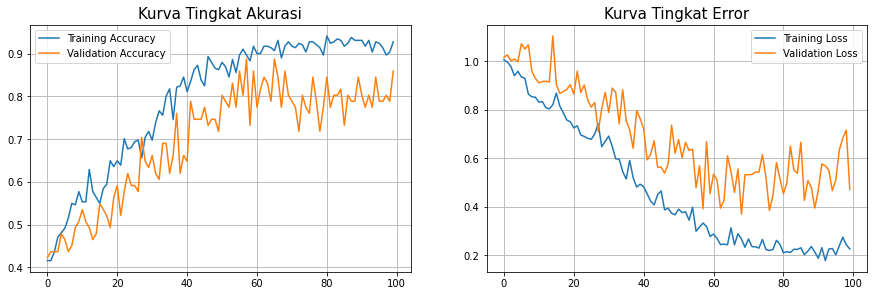

time: 287 ms


In [ ]:
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(history.history["acc"], label = "Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder=0)
 
plt.subplot(2, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder=0)
plt.show()

Menggunakan Model

In [ ]:
print(train_generator)

time: 1.62 ms


In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

time: 1.18 ms


Evaluasi

In [ ]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0
 1 0 2 0 0 0 0 0 0 0 1 1 1 0 2 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 2
 1 2 1 0 1 2 0 0 0 0 0 0 1 1 1 2 0 2 1 0 0 1 2 1 1 0 1 1 0 0 1 2 1 1 0 1 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 2 2 0 0 2 0 2 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 1 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

Membuat Confusion Matrix

Normalized confusion matrix
[[0.87 0.06 0.07]
 [0.41 0.49 0.09]
 [0.12 0.04 0.84]]


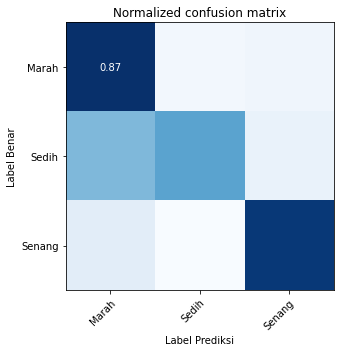

time: 182 ms


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if not title:
    if normalize:
      title = 'Normalized confusion matrix'
    else:
      title = 'Confusion matrix, without normalization'

  #compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  #Only use the labels that appear in the data
  #classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np. newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  fig, ax = plt.subplots(figsize=(5,5))
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  #ax.figure.colorbar(im, ax=ax)
  #we want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         #...and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title=title,
         ylabel='Label Benar',
         xlabel='Label Prediksi')
  
  #Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")
  #Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], fmt),
              ha="center", va="center",
              color="white" if cm[i, j] > thresh else "black")
      fig.tight_layout()
      return ax

np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

Menyimpan dan Konversi Model ke ".tfllite"

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Emotion_Detection_MobileNet.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets


INFO:tensorflow:Assets written to: save/model/assets


time: 14.2 s


Menyimpan model tflite versi kompatibel quantized

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open('Emotion_Detection_MobileNet_Quantized', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets


INFO:tensorflow:Assets written to: save/model/assets


time: 13.8 s


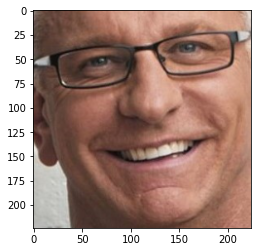

Label yang benar adalah: 2 : Senang
Nilai yang diprediksi adalah: [0.04 0.12 0.84]
Label yang diprediksi adalah: 2 : Senang
Prediksi benar
time: 1.05 s


In [ ]:
n = 199

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1) [n]
print("Label yang benar adalah:", true_label,":", labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
  print("Prediksi benar")
else:
  print("Prediksi salah")

In [ ]:
# USAGE
# python detect_mask_image.py --image examples/example_01.png
 
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow
 
# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread('.jpg')
orig = image.copy()
(h, w) = image.shape[:2]
 
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
    (104.0, 177.0, 123.0))
 
net=cv2.dnn.readNet('/face_detector/deploy.prototxt','/face_detector/res10_300x300_ssd_iter_140000.caffemodel')
 
# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()
 
# loop over the detections
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]
 
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.5:
        # compute the (x, y)-coordinates of the bounding box for
        # the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
 
        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
 
        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
 
        # pass the face through the model to determine if the face
        # has a mask or not
        (mask, withoutMask) = model.predict(face)[0]
 
        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
 
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
 
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
 
# show the output image
cv2_imshow(image)
cv2.waitKey(0)